In [161]:
import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn
import lightning as L 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [139]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [140]:
sample_rate = 10000

def generate_qpsk_iq_samples(
    num_samples: int, 
    bits_per_sample: int, 
    carrier_freq=50,
    symbol_rate=100,
    sample_rate=sample_rate,
    noise_power=0.1
):

    samples_per_symbol = sample_rate // symbol_rate
    symbols_per_sample = bits_per_sample // 2  
    samples_per_sample = symbols_per_sample * samples_per_symbol

    all_clean_I = np.zeros((num_samples, samples_per_sample))
    all_clean_Q = np.zeros((num_samples, samples_per_sample))
    all_noised_I = np.zeros((num_samples, samples_per_sample))
    all_noised_Q = np.zeros((num_samples, samples_per_sample))

    iq_map = {
        (0, 0): (np.sqrt(0.5), np.sqrt(0.5)),
        (0, 1): (-np.sqrt(0.5), np.sqrt(0.5)),
        (1, 1): (-np.sqrt(0.5), -np.sqrt(0.5)),
        (1, 0): (np.sqrt(0.5), -np.sqrt(0.5))
    }

    for sample_idx in range(num_samples):

        binary_data = np.random.randint(0, 2, bits_per_sample).reshape(-1, 2)
        t = np.arange(0, samples_per_sample) / sample_rate

        I = np.zeros(samples_per_sample)
        Q = np.zeros(samples_per_sample)

        for i, (b1, b2) in enumerate(binary_data):
            i_val, q_val = iq_map[(b1, b2)]
            start = i * samples_per_symbol
            end = start + samples_per_symbol
            I[start:end] = i_val
            Q[start:end] = q_val

        # Модуляция
        I_modulated = I * np.cos(2 * np.pi * carrier_freq * t)
        Q_modulated = Q * np.sin(2 * np.pi * carrier_freq * t)

        # Добавляем шум после модуляции
        noise_I_mod = np.random.normal(0, noise_power, samples_per_sample)
        noise_Q_mod = np.random.normal(0, noise_power, samples_per_sample)

        I_modulated_noised = I_modulated + noise_I_mod
        Q_modulated_noised = Q_modulated + noise_Q_mod

        all_clean_I[sample_idx] = I_modulated
        all_clean_Q[sample_idx] = Q_modulated
        all_noised_I[sample_idx] = I_modulated_noised
        all_noised_Q[sample_idx] = Q_modulated_noised
        
    return all_clean_I, all_clean_Q, all_noised_I, all_noised_Q


In [141]:
class CustomDataset(Dataset):
    def __init__(self, 
                 num_samples=1000,
                 bits_per_sample=200,
                 carrier_freq=50,
                 symbol_rate=100,
                 sample_rate=1000,
                 noise_power=0.1):
     

        (self.I_clean, self.Q_clean, 
         self.I_noisy, self.Q_noisy,) = generate_qpsk_iq_samples(
            num_samples=num_samples,
            bits_per_sample=bits_per_sample,
            carrier_freq=carrier_freq,
            symbol_rate=symbol_rate,
            sample_rate=sample_rate,
            noise_power=noise_power
        )
        

        self.clean = torch.stack([
            torch.FloatTensor(self.I_clean),
            torch.FloatTensor(self.Q_clean)
        ], dim=1)  
        
        self.noisy = torch.stack([
            torch.FloatTensor(self.I_noisy),
            torch.FloatTensor(self.Q_noisy)
        ], dim=1)  

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx] 

In [142]:
class CNNEncoder(nn.Module):
    def __init__(self, input_channels=2, embed_dim=64):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=2, padding=2),  
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
        )
        

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.projection = nn.Linear(128, embed_dim)

    def forward(self, x):
 
        #x = x.permute(0, 2, 1)
        
        features = self.conv_layers(x)  
        pooled = self.global_pool(features).squeeze(-1) 
        embeddings = self.projection(pooled)
        
        return embeddings

In [143]:
class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=64, output_channels=2, target_len=sample_rate):
        super().__init__()
        self.target_len = target_len
        self.upsample = nn.Linear(embed_dim, 128 * (target_len // 8))  
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.ConvTranspose1d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
        )

    def forward(self, z):
        x = self.upsample(z).view(-1, 128, self.target_len // 8)
        x = self.conv_layers(x)  # (batch_size,2,target_len)
        return x.permute(0, 2, 1)  # (batch_size,target_len,2)

In [144]:
dataset = CustomDataset(
    num_samples=1000,
    bits_per_sample=200,
    noise_power=0.2
)

In [145]:
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=False,
)

In [146]:
for batch_noisy, batch_clean in dataloader:
    print(f"Noisy batch shape: {batch_noisy.shape}")  # (32, 2, 1000)
    print(f"Clean batch shape: {batch_clean.shape}")  # (32, 2, 1000)
    break

Noisy batch shape: torch.Size([128, 2, 1000])
Clean batch shape: torch.Size([128, 2, 1000])


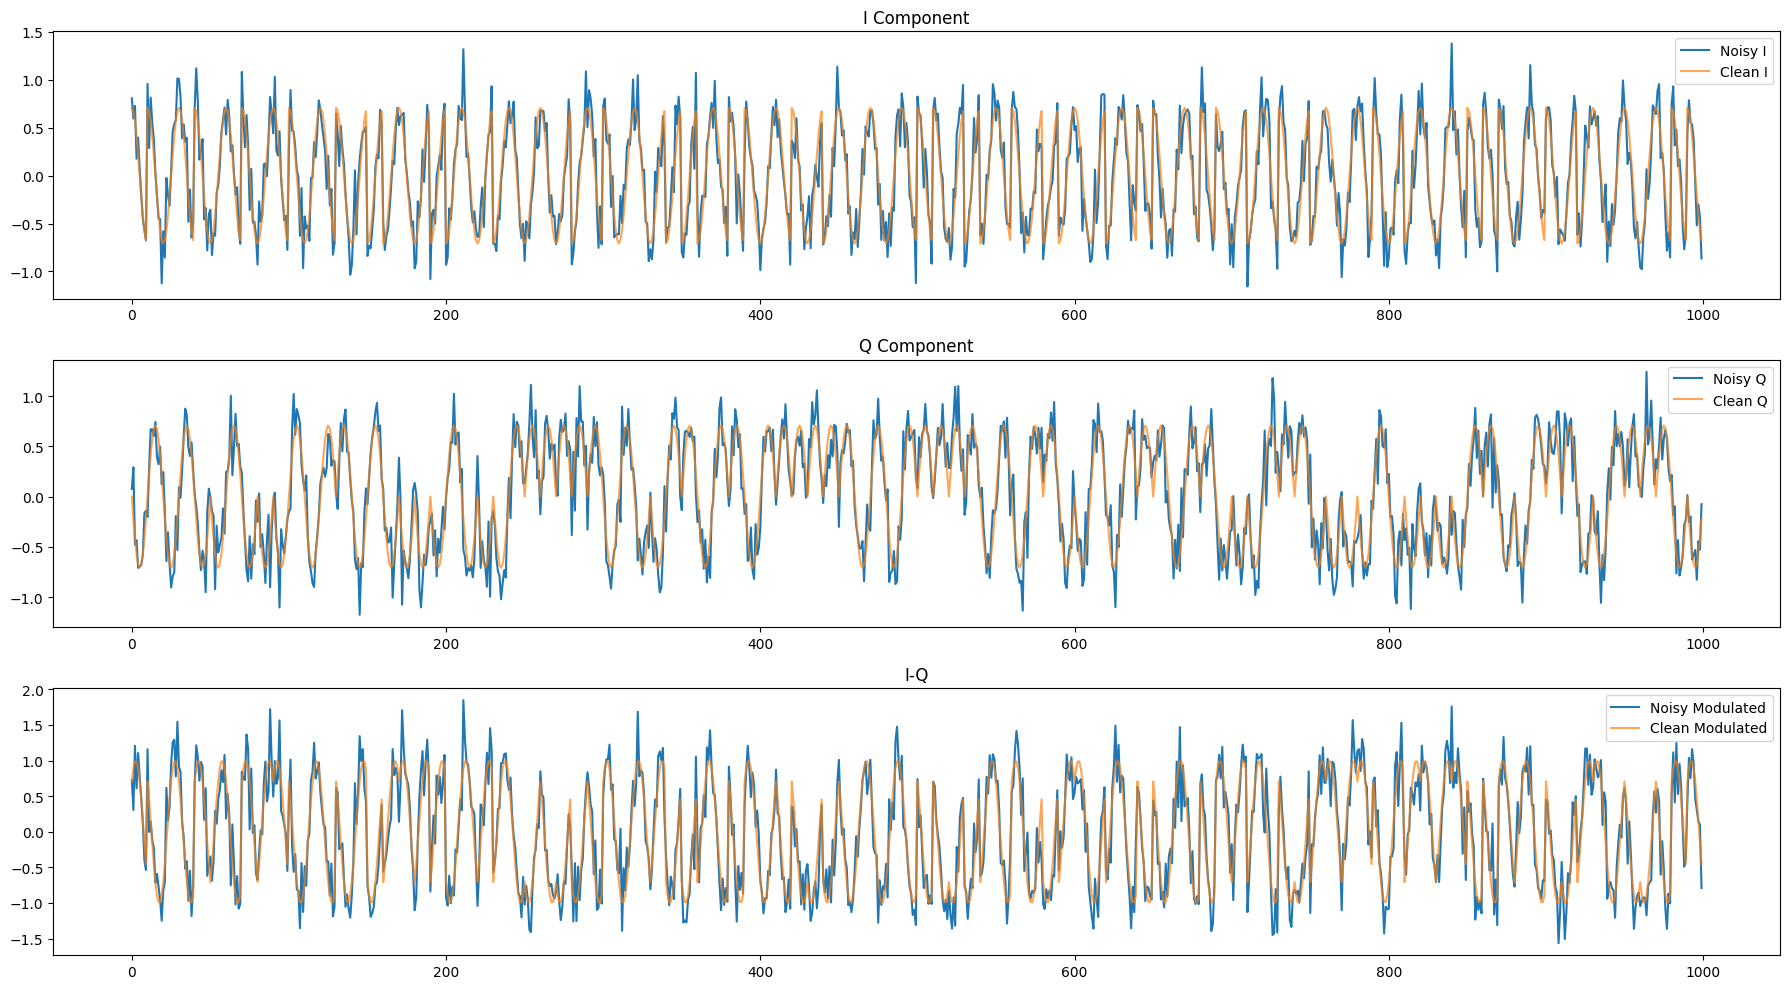

In [147]:
noisy, clean = dataset[0]

plt.figure(figsize=(18, 10))

# I компонент
plt.subplot(3, 1, 1)
plt.plot(noisy[0].numpy(), label='Noisy I')
plt.plot(clean[0].numpy(), label='Clean I', alpha=0.7)
plt.legend()
plt.title("I Component")

# Q компонент
plt.subplot(3, 1, 2)
plt.plot(noisy[1].numpy(), label='Noisy Q')
plt.plot(clean[1].numpy(), label='Clean Q', alpha=0.7)
plt.legend()
plt.title("Q Component")


t = np.arange(0, len(clean[0])) / sample_rate
modulated_clean = clean[0].numpy()  - clean[1].numpy() 
modulated_noisy = noisy[0].numpy() -noisy[1].numpy() 

plt.subplot(3, 1, 3)
plt.plot(modulated_noisy, label='Noisy Modulated')
plt.plot(modulated_clean, label='Clean Modulated', alpha=0.7)
plt.legend()
plt.title("I-Q")

plt.tight_layout()
plt.show()


In [148]:
class Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [149]:
model = Denoiser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def nt_xent_loss(z_i, z_j, temperature=0.7):


    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  
    z = F.normalize(z, dim=1) 

    similarity_matrix = torch.matmul(z, z.T)  
    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)
    positives = torch.cat([sim_ij, sim_ji], dim=0)  

    # Создаём маску, чтобы исключить самих себя из отрицательных
    diag_mask = torch.eye(2 * batch_size, device=z.device).bool()
    positives_mask = torch.zeros_like(diag_mask)
    positives_mask[:batch_size, batch_size:] = True
    positives_mask[batch_size:, :batch_size] = True
    negatives_mask = ~diag_mask & ~positives_mask

    logits = similarity_matrix / temperature
    logits = logits.masked_select(negatives_mask).view(2 * batch_size, -1)
    labels = torch.zeros(2 * batch_size, device=z.device, dtype=torch.long)  # положительная пара = класс 0

    loss = F.cross_entropy(logits, labels)
    return loss

In [151]:
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for noisy, clean in dataloader:
        noisy = noisy.to(device)
        clean = clean.to(device)

        z_noisy = model.encoder(noisy)
        z_clean = model.encoder(clean)

        loss = nt_xent_loss(z_noisy, z_clean, temperature=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - NT-Xent Loss: {avg_loss:.4f}")


Epoch [1/10000] - NT-Xent Loss: 4.8210
Epoch [2/10000] - NT-Xent Loss: 4.7902
Epoch [3/10000] - NT-Xent Loss: 4.6781
Epoch [4/10000] - NT-Xent Loss: 4.6219
Epoch [5/10000] - NT-Xent Loss: 4.5740
Epoch [6/10000] - NT-Xent Loss: 4.5326
Epoch [7/10000] - NT-Xent Loss: 4.4911
Epoch [8/10000] - NT-Xent Loss: 4.4824
Epoch [9/10000] - NT-Xent Loss: 4.4825
Epoch [10/10000] - NT-Xent Loss: 4.4704
Epoch [11/10000] - NT-Xent Loss: 4.4437
Epoch [12/10000] - NT-Xent Loss: 4.4359
Epoch [13/10000] - NT-Xent Loss: 4.4263
Epoch [14/10000] - NT-Xent Loss: 4.4285
Epoch [15/10000] - NT-Xent Loss: 4.4318
Epoch [16/10000] - NT-Xent Loss: 4.4292
Epoch [17/10000] - NT-Xent Loss: 4.4300
Epoch [18/10000] - NT-Xent Loss: 4.4203
Epoch [19/10000] - NT-Xent Loss: 4.4143
Epoch [20/10000] - NT-Xent Loss: 4.4156
Epoch [21/10000] - NT-Xent Loss: 4.4137
Epoch [22/10000] - NT-Xent Loss: 4.4052
Epoch [23/10000] - NT-Xent Loss: 4.4018
Epoch [24/10000] - NT-Xent Loss: 4.3984
Epoch [25/10000] - NT-Xent Loss: 4.3964
Epoch [26

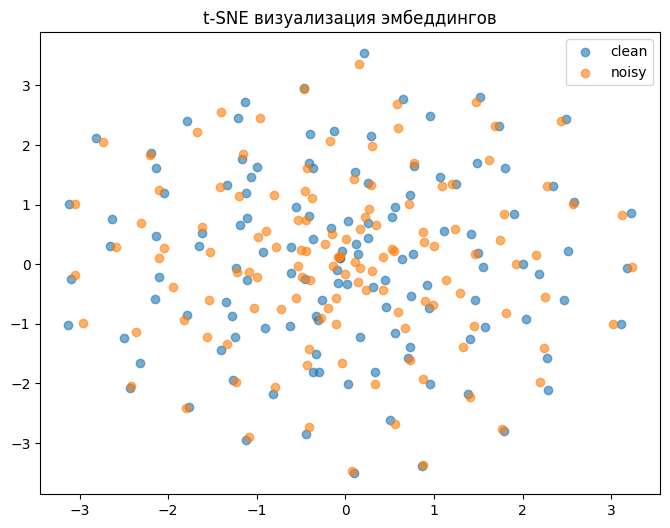

In [152]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Вытаскиваем батч
noisy_batch, clean_batch = next(iter(dataloader))
noisy_batch = noisy_batch.to(device)
clean_batch = clean_batch.to(device)

# Получаем эмбеддинги
z_noisy = model.encoder(noisy_batch).detach().cpu().numpy()
z_clean = model.encoder(clean_batch).detach().cpu().numpy()

# Объединяем и визуализируем через t-SNE
embeddings = np.concatenate([z_noisy, z_clean], axis=0)
labels = ['noisy'] * len(z_noisy) + ['clean'] * len(z_clean)

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
emb_2d = tsne.fit_transform(embeddings)

# Рисуем
plt.figure(figsize=(8, 6))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(emb_2d[indices, 0], emb_2d[indices, 1], label=label, alpha=0.6)

plt.legend()
plt.title("t-SNE визуализация эмбеддингов")
plt.show()


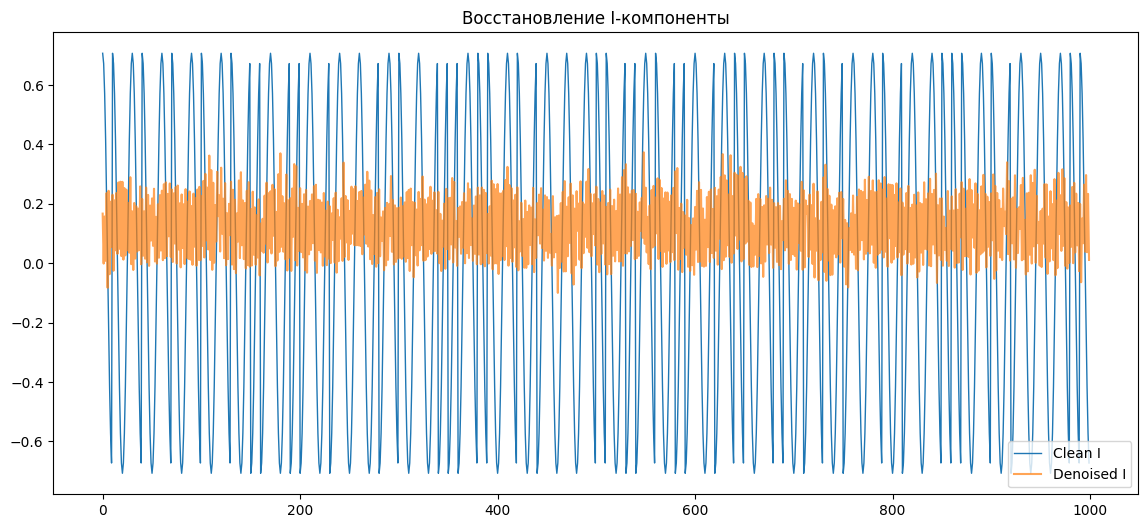

In [162]:
model.eval()
noisy_batch, clean_batch = next(iter(dataloader))
noisy_batch = noisy_batch.to(device)
clean_batch = clean_batch.to(device)

with torch.no_grad():
    denoised = model(noisy_batch).cpu()

# Визуализация восстановления
i = 0  # индекс сигнала в батче
plt.figure(figsize=(14, 6))
plt.plot(clean_batch[i, 0].cpu(), label="Clean I", linewidth=1)
plt.plot(denoised[i, :1000, 0], label="Denoised I", alpha=0.7)
plt.legend()
plt.title("Восстановление I-компоненты")
plt.show()

In [154]:
denoised[0].shape

torch.Size([10000, 2])

In [159]:
torch.save(model, 'modulation1_params.pt')

In [168]:
clean_array = clean_batch[0, 0].cpu().numpy()

In [171]:
sim1 =clean_array.reshape(1,-1)
sim2 = denoised[0, :1000, 0].reshape(1,-1)

In [172]:
cosine_distances(sim1,sim2)

array([[0.98087764]], dtype=float32)

In [173]:
cosine_similarity(sim1,sim2)

array([[0.01912234]], dtype=float32)